## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [392]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import seaborn as sns
from itertools import cycle, islice

In [393]:
data=pd.read_csv('/datasets/taxi.csv', index_col=[0],parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Text(0.5, 1.0, 'Число заказов')

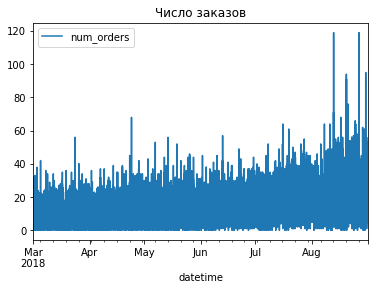

In [394]:
data.plot()
plt.title('Число заказов')

На графике приведено количество заказов с интервалом в 10 минут. График довольно шумный из него пока ничего не понятно. Данные не стационарные, меняется среднее значение и стандартное отклонение.

### Ресемплирование данных

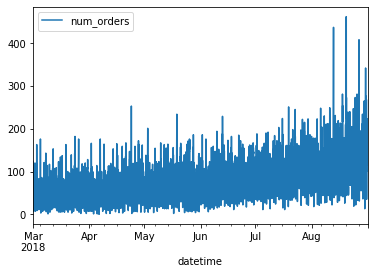

In [395]:
# выполним ресэплирование данных по одному часу
data=data.resample('1H').sum()
data.plot()

В дальнейшем будем строить предсказание в пределах одного часа, поэтому ресеплирование по одному часу. Sum(), так как нас интересует общее число заказов такси в час.

# 2. Анализ

### 2.1 Анализ тренда и сезонности по всем данным

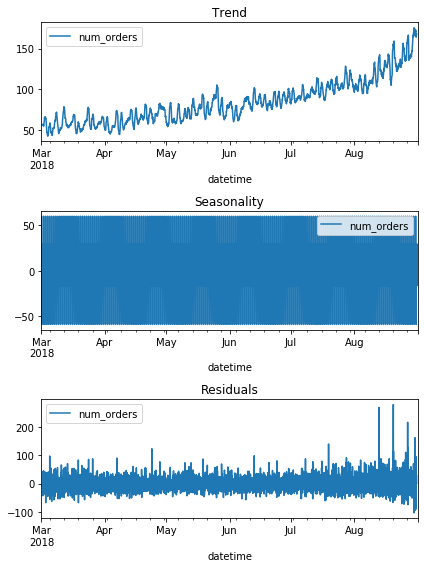

In [396]:
# посмотрии тренд и сезонность в течении всего перида наблюдений
decomposed = seasonal_decompose(data)
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Общий тренд-плавное увеличени среднего кол-ва заказов от марта к сентябрю. Сезонности не обнаружено.

### 2.2 Анализ тренда и сезонности в течении месяца

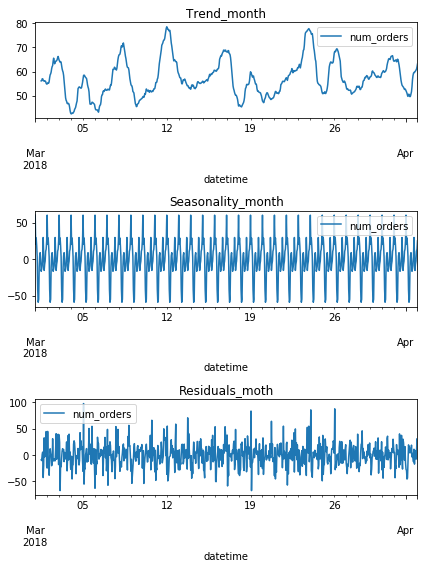

In [397]:
# посмотрим тренд и сезонность в течении месяца
decomposed = seasonal_decompose(data)
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend['2018-03-01':'2018-04-01'].plot(ax=plt.gca())
plt.title('Trend_month')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-04-01'].plot(ax=plt.gca()) 
plt.title('Seasonality_month')
plt.subplot(313)
decomposed.resid['2018-03-01':'2018-04-01'].plot(ax=plt.gca())
plt.title('Residuals_moth')
plt.tight_layout()

В течении месяца отсутвует какой-либо тренд. Есть сезонность в течении дня. Рассотрим её подробнее

### 2.4 Анализ  сезонности в течении дня

Text(0, 0.5, 'число заказов')

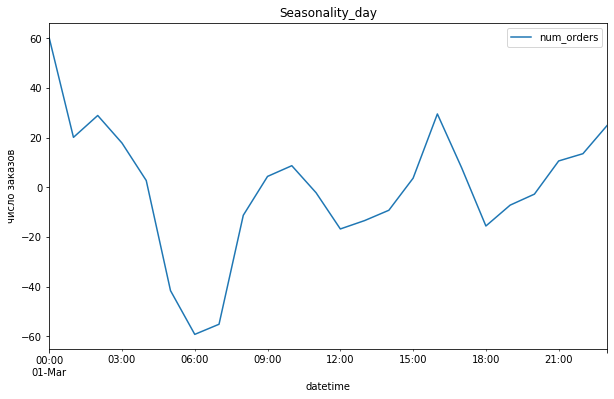

In [398]:
# посмотрим тренд и сезонность в течении дня
decomposed = seasonal_decompose(data)
plt.figure(figsize=(10, 6))
decomposed.seasonal['2018-03-01'].plot(ax=plt.gca()) 
plt.title('Seasonality_day')
plt.ylabel('число заказов')

В целом, количество заказов максимально в 24 часа ночи, затем идёт на спад, и достигает своего минимального значения к 6 утра.
После 6 кол-во заказов быстро увеличиается до 9 утра, а затем в течении дня колеблется. После 18 вечера число заказов возрастает, достигая пика в 24 часа ночи.

### 2.5 Изучим кол-во заказов по дням недели

In [399]:
# вынесем в отдельный столбец дни недели
data['dayofweek'] = data.index.dayofweek

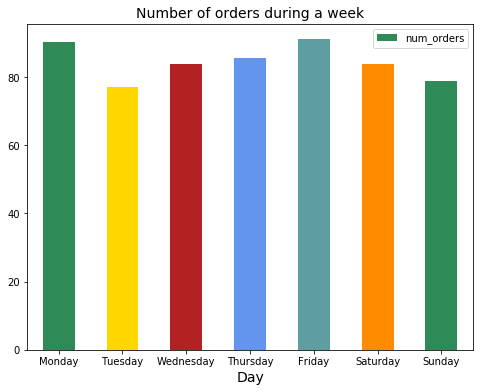

In [400]:
data_2=data.pivot_table(index='dayofweek', values='num_orders', aggfunc='mean').reset_index(drop=True)

plt.figure(figsize=(8,6))
my_colors = list(islice(cycle(['seagreen', 'gold', 'firebrick', 'cornflowerblue', 'cadetblue','darkorange']), None, len(data_2)))
days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]           
data_2.plot.bar(y='num_orders',rot=0,ax=plt.gca(), color=my_colors)
plt.xticks(np.arange(data_2.shape[0]),days)
plt.xlabel("Day",fontsize=14)
plt.title("Number of orders during a week",fontsize=14)
plt.show()

Максимальное кол-во заказов приходятся на понедельник и пятницу. Минимальное на вторник.

### Вывод

<div> 1)Есть общий тренд- с марта по сентябрь число заказов увеличивается. Существует сезонность в течении дня-число заказов изменяется с чёткой закономерностью. Нет сезонности по месяцам. Кроме того, число заказов изменяется в зависимости от дня недели.</div>

<div> 2)Таким образом, пресказание кол-ва заказов каждый следующий час будет зависить от времени дня, дня недели и месяца. От года и календарного дня число заказов не зависит. </div>


In [401]:
# добавим в призники месяц
data['month'] = data.index.month
data['hour'] = data.index.hour

In [402]:
# сделаем shift в 24 часа, так как закономерность изменения кол-ва заказов по часам наблюдается в пределах одного дня.
for lag in range(1, 25):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

In [403]:
# сделаем также shift на семь дней, как кол-во заказов изменяется в пределах недели.        
for n in range(1, 8):
        data['n_{}'.format(n)] = data['num_orders'].shift(24*n) 

In [404]:
# сделаем также shift на 8 месяцев, как кол-во заказов увеличивается от месяца к месяцу. 
for m in range(1, 7):
        data['m_{}'.format(m)] = data['num_orders'].shift(24*7*m)  

In [405]:
data['rolling_mean']=data['num_orders'].shift().rolling(8).mean()

# 3. Обучение

In [406]:
from sklearn.model_selection import train_test_split

In [407]:
train_valid, test = train_test_split(data, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.12)

Пеперь размер обучающей выборки -70%, размер валидационной-20%, тестовой-10%

In [408]:
features_train=train.drop(['num_orders'],axis=1)
target_train=train['num_orders']


features_valid=valid.drop(['num_orders'],axis=1)
target_valid=valid['num_orders']

features_test=test.drop(['num_orders'],axis=1)
target_test=test['num_orders']

### 3.1 Обучение модели LinearRegression

Так как у LinearRegression нет гиперпараметров, то не получится отрегулировать сложность модели.

In [409]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [410]:
data_linear=data.fillna(0)
train_valid_l, test_l = train_test_split(data_linear, shuffle=False, test_size=0.1)
train_l, valid_l = train_test_split(train_valid_l, shuffle=False, test_size=0.12)

features_train_l=train_l.drop(['num_orders'],axis=1)
target_train_l=train_l['num_orders']


features_valid_l=valid_l.drop(['num_orders'],axis=1)
target_valid_l=valid_l['num_orders']

features_test_l=test_l.drop(['num_orders'],axis=1)
target_test_l=test_l['num_orders']

In [411]:
model_linear=LinearRegression()

model_linear.fit(features_train_l, target_train_l)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [412]:
predict_valid_linear=model_linear.predict(features_valid_l)

In [413]:
mse = mean_squared_error(target_valid_l, predict_valid_linear)
RMSE_valid_liner=print("RMSE_valid =", '{:.2f}'.format(mse ** 0.5))
RMSE_valid_linear=mse**0.5

RMSE_valid = 27.56


### 3.2 Обучение модели LightGBMRegressor

In [414]:
from lightgbm import LGBMRegressor

In [415]:
    best_param=[]
    i=1000000
    for estimators in range(100,200,50):
        for depth in range(10,100,10):
            model_GBM=LGBMRegressor( max_depth=depth, n_estimators=estimators,random_state=2018)
            result=model_GBM.fit(features_train,target_train,eval_set=(features_valid, target_valid))
            predict_valid_GBM=model_GBM.predict(features_valid)
            mse = mean_squared_error(target_valid, predict_valid_GBM)
            RMSE=mse**0.5
            if RMSE <i:
                best_param=[]
                best_param.append({'RMSE':RMSE})
                best_param.append({'n_estimators':estimators})
                best_param.append({'depth':depth})
                i=RMSE 

[1]	valid_0's l2: 2932.43
[2]	valid_0's l2: 2597.07
[3]	valid_0's l2: 2307.98
[4]	valid_0's l2: 2069.89
[5]	valid_0's l2: 1876.29
[6]	valid_0's l2: 1715.8
[7]	valid_0's l2: 1566.52
[8]	valid_0's l2: 1436.93
[9]	valid_0's l2: 1355.72
[10]	valid_0's l2: 1271.66
[11]	valid_0's l2: 1202.57
[12]	valid_0's l2: 1142.23
[13]	valid_0's l2: 1098.57
[14]	valid_0's l2: 1060
[15]	valid_0's l2: 1021.06
[16]	valid_0's l2: 988.905
[17]	valid_0's l2: 968.9
[18]	valid_0's l2: 936.05
[19]	valid_0's l2: 910.874
[20]	valid_0's l2: 891.558
[21]	valid_0's l2: 878.624
[22]	valid_0's l2: 863.574
[23]	valid_0's l2: 856.007
[24]	valid_0's l2: 845.394
[25]	valid_0's l2: 836.066
[26]	valid_0's l2: 831.622
[27]	valid_0's l2: 822.059
[28]	valid_0's l2: 813.392
[29]	valid_0's l2: 811.004
[30]	valid_0's l2: 806.459
[31]	valid_0's l2: 804.265
[32]	valid_0's l2: 802.091
[33]	valid_0's l2: 799.661
[34]	valid_0's l2: 797.218
[35]	valid_0's l2: 796.235
[36]	valid_0's l2: 792.29
[37]	valid_0's l2: 790.66
[38]	valid_0's l2: 

In [416]:
# посмотрим параметры с наименьшим RMSE
best_param

[{'RMSE': 27.72928355458222}, {'n_estimators': 100}, {'depth': 10}]

In [417]:
model_GBM= LGBMRegressor(n_estimators=100,max_depth=10)
model_GBM.fit(features_train, target_train)
predict_valid_GBM=model_GBM.predict(features_valid)


In [418]:
mse_gbm = mean_squared_error(target_valid, predict_valid_GBM)
RMSE_valid_GBM=print("RMSE_valid =", '{:.2f}'.format(mse_gbm ** 0.5))
RMSE_valid_GBM=mse**0.5

RMSE_valid = 27.73


### 3.3 Обучение модели CatBoostRegressor

In [419]:
from catboost import CatBoostRegressor

In [420]:
best_param=[]
i=1000000
for estimators in range(100,200,50):
    for depth in range(1,10,1):
        model_cat=CatBoostRegressor( max_depth=depth, n_estimators=estimators,random_state=2018)
        result=model_cat.fit(features_train,target_train,eval_set=(features_valid, target_valid))
        predict_valid_cat=model_cat.predict(features_valid)
        mse = mean_squared_error(target_valid, predict_valid_cat)
        RMSE=mse**0.5
        if RMSE <i:
            best_param=[]
            best_param.append({'RMSE':RMSE})
            best_param.append({'n_estimators':estimators})
            best_param.append({'depth':depth})
            i=RMSE 

0:	learn: 35.2330495	test: 57.2386072	best: 57.2386072 (0)	total: 70.5ms	remaining: 6.98s
1:	learn: 34.9085967	test: 56.8071180	best: 56.8071180 (1)	total: 71.4ms	remaining: 3.5s
2:	learn: 34.5719393	test: 56.4258125	best: 56.4258125 (2)	total: 72.2ms	remaining: 2.33s
3:	learn: 34.2425898	test: 55.9149015	best: 55.9149015 (3)	total: 73.1ms	remaining: 1.75s
4:	learn: 33.9269339	test: 55.4057004	best: 55.4057004 (4)	total: 73.9ms	remaining: 1.41s
5:	learn: 33.6249942	test: 55.0851671	best: 55.0851671 (5)	total: 74.8ms	remaining: 1.17s
6:	learn: 33.3336293	test: 54.6646717	best: 54.6646717 (6)	total: 75.7ms	remaining: 1s
7:	learn: 33.0571367	test: 54.3446320	best: 54.3446320 (7)	total: 76.5ms	remaining: 880ms
8:	learn: 32.7911321	test: 53.8884558	best: 53.8884558 (8)	total: 77.4ms	remaining: 782ms
9:	learn: 32.5252632	test: 53.6314372	best: 53.6314372 (9)	total: 78.2ms	remaining: 704ms
10:	learn: 32.2657420	test: 53.1955074	best: 53.1955074 (10)	total: 147ms	remaining: 1.19s
11:	learn: 32

In [421]:
#посмотрит параметры с наименьшим RMSE
best_param

[{'RMSE': 28.71375969453794}, {'n_estimators': 150}, {'depth': 6}]

In [422]:
model_cat= CatBoostRegressor(n_estimators=150, depth=6)
model_cat.fit(features_train, target_train,verbose=150)
predict_valid_cat=model_cat.predict(features_valid)

0:	learn: 34.9957045	total: 59.9ms	remaining: 8.92s
149:	learn: 18.3091014	total: 5.01s	remaining: 0us


In [423]:
mse = mean_squared_error(target_valid, predict_valid_cat)
RMSE_valid_cat=print("RMSE_valid =", '{:.2f}'.format(mse ** 0.5))
RMSE_valid_cat=mse**0.5

RMSE_valid = 28.66


# 4. Тестирование

### 4.1 Тест модели LinearRegression

In [424]:
predict_test_linear = model_linear.predict(features_test_l)
mse = mean_squared_error(target_test_l, predict_test_linear)
RMSE_test_linear=print("RMSE_test =", '{:.2f}'.format(mse ** 0.5))
RMSE_test_linear=mse**0.5

RMSE_test = 36.07


### 4.2 Тест модели LightGBMRegressor

In [425]:
predict_test_GBM = model_GBM.predict(features_test)
mse = mean_squared_error(target_test, predict_test_GBM)
RMSE_test_GBM=print("RMSE_test =", '{:.2f}'.format(mse ** 0.5))
RMSE_test_GBM=mse**0.5


RMSE_test = 43.87


### 4.3 Тест модели CatBoostRegressor

In [426]:
predict_test_cat = model_cat.predict(features_test)
mse = mean_squared_error(target_test, predict_test_cat)
RMSE_test_cat=print("RMSE_test =", '{:.2f}'.format(mse ** 0.5))
RMSE_test_cat=mse**0.5


RMSE_test = 47.71


### 4.4 Сводная таблица

In [427]:
data2 = {'Model':['LinearRegression','LightGBMR','CatBoost'], 'RMSE_valid':[RMSE_train_linear, RMSE_valid_GBM, RMSE_valid_cat],
        'RMSE_test':[RMSE_test_linear,RMSE_test_GBM,RMSE_test_cat]}
df = pd.DataFrame(data2).round(decimals=2).reset_index(drop=True)
df

,Model,RMSE_valid,RMSE_test
0,LinearRegression,27.39,36.07
1,LightGBMR,27.79,43.87
2,CatBoost,28.66,47.71


### Выводы

На обучающей и тестовой выборке лучшие предсказания получились на модели LinearRegression.	